---

# Atenção!

Lembre-se de clonar este notebook antes de tentar editar as células de código.

Para isso, basta seguir os passos:

File -> Save a copy in Drive



---

# Epílogo

## Mais de um caixeiro viajante?

Vimos na aula anterior que o Problema do Caixeiro Viajante, ou Traveling Salesperson Problem (TSP) consiste em determinar uma rota que percorra um conjunto `n` de cidades/localizações/nós sem repetição e com o menor custo total.

Uma extensão quase que imediata desde problema é quando temos mais de um caixeiro para percorrer os mesmos nós. Neste caso, podemos paralelizar o processo e obter várias rotas cuja soma total é menor do que com apenas um caixeiro, como o exemplo abaixo com dois viajantes visitando os cinco nós. Neste caso não é necessário que cada caixeiro percorra todos os nós, apenas que ao final todas as localizações tenham sido visitadas.

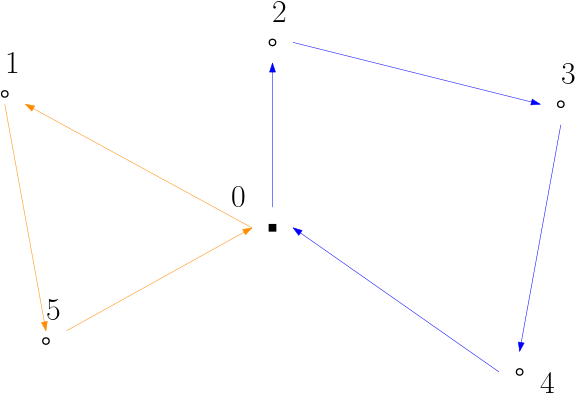



O problema neste caso é conhecido como [multiple Traveling Salesperson Problem](https://neos-guide.org/content/multiple-traveling-salesman-problem-mtsp) (mTSP). Existem algoritmos especialmente desenvolvidos para resolvê-lo, mas aqui vamos simplesmente adaptar o método da aula anterior.

## Resolvendo o mTSP

Vamos utilizar novamente a biblioteca [OR-Tools](https://developers.google.com/optimization) para aproveitar a familiaridade obtida na aula anterior para resolver o mTSP.

In [ ]:
!pip install ortools==9.0.9048

Lembre que nos passos iniciais nós construímos um gerenciador de índices com a sintaxe

```python
manager = pywrapcp.RoutingIndexManager(n, num_vehicles, depot_node)
```

em que `n` é o número total de nós do problema e `depot_node` é o nó de partida. No código anterior, `num_vehicles` tinha sempre o valor 1 porque havia apenas um caixeiro. Assim, podemos resolver o mTSP apenas adaptando esta variável.

Vamos retomar o problema de exemplo da aula passada levemente modificado:


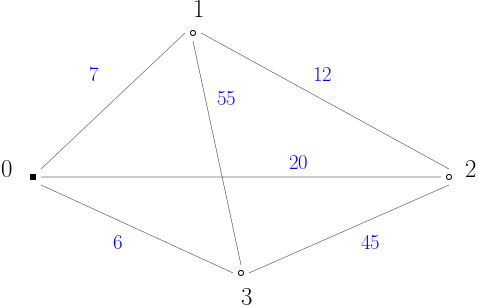



A diferença aqui é que ir para o nó 3 de qualquer ponto fora a origem é bem mais custoso. Intuitivamente, podemos pensar que valeria a pena alocar um caixeiro saindo do 0 e visitando apenas o nó 3 e o outro visitando os nós restantes. Vamos ver se nosso algoritmo também pensa assim.

Aqui está sua matriz equivalente de distâncias:

In [ ]:
import numpy as np


distance_matrix = np.array([
    [0, 7, 20, 6],
    [7, 0, 12, 45],
    [20, 12, 0, 55],
    [6, 55, 45, 0],
])
distance_matrix

Vamos tentar resolver este problema com dois caixeiros viajantes.

Assumindo que a memória esteja ainda boa com o algoritmo da última aula, aqui está uma parte de código para resolvê-lo (observe que fora `num_vehicles = 2` tudo é igual):

In [ ]:
from ortools.constraint_solver import pywrapcp

n = distance_matrix.shape[0]  # número de nós do problema
num_vehicles = 2
depot_node = 0  # número do nó que representa o ponto de origem
manager = pywrapcp.RoutingIndexManager(n, num_vehicles, depot_node)
routing = pywrapcp.RoutingModel(manager)

def distance_callback(i, j):
    # `i` e `j` são índices internos do OR-Tools. Precisamos primeiro
    # convertê-los em nós do nosso problema
    ni = manager.IndexToNode(i)
    nj = manager.IndexToNode(j)
    return distance_matrix[ni, nj]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Resolve o problema com métodos default
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
solution = routing.SolveWithParameters(search_parameters)
solution.ObjectiveValue()

Como antes, o problema é resolvido e sabemos a distância total, mas precisamos de alguns passos a mais para retornar as rotas geradas.

O ponto de partida antes era `routing.Start(0)`. O `0` significa "caixeiro viajante com índice `0`", e no caso anterior havia apenas um. Usando o mesmo código de antes, aqui está a rota seguida por este caixeiro:

In [ ]:
route = []
index = routing.Start(0)
node = manager.IndexToNode(index)
route.append(node)

while not routing.IsEnd(index):
    index = solution.Value(routing.NextVar(index))
    node = manager.IndexToNode(index)
    route.append(node)
route

E como previsto, uma das rotas consiste em visitar apenas o nó `3`. A outra solução é obtida fornecendo o índice `1` (do segundo caixeiro) como ponto de partida para o mesmo código:

In [ ]:
route = []
index = routing.Start(1)
node = manager.IndexToNode(index)
route.append(node)

while not routing.IsEnd(index):
    index = solution.Value(routing.NextVar(index))
    node = manager.IndexToNode(index)
    route.append(node)
route

E ela cobre os nós restantes.
Podemos generalizar o processo criando uma função que recebe o índice de cada caixeiro:

In [ ]:
def create_vehicle_route(vehicle_index):
    route = []
    index = routing.Start(vehicle_index)
    node = manager.IndexToNode(index)
    route.append(node)

    while not routing.IsEnd(index):
        index = solution.Value(routing.NextVar(index))
        node = manager.IndexToNode(index)
        route.append(node)
    return route

routes = []
for vehicle_index in range(num_vehicles):
    route = create_vehicle_route(vehicle_index)
    routes.append(route)
routes

Juntando todo o código, temos uma função que resolve o mTSP dada uma matriz de distâncias e o número desejado de caixeiros:

In [ ]:
from ortools.constraint_solver import pywrapcp


def solve_mtsp_ortools(distance_matrix, num_vehicles=1):
    n = distance_matrix.shape[0]  # número de nós do problema
    depot_node = 0  # número do nó que representa o ponto de origem
    manager = pywrapcp.RoutingIndexManager(n, num_vehicles, depot_node)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(i, j):
        # `i` e `j` são índices internos do OR-Tools. Precisamos primeiro
        # convertê-los em nós do nosso problema
        ni = manager.IndexToNode(i)
        nj = manager.IndexToNode(j)
        return distance_matrix[ni, nj]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Resolve o problema com métodos default
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    solution = routing.SolveWithParameters(search_parameters)

    # Constrói as rotas finais
    def create_vehicle_route(vehicle_index):
        route = []
        index = routing.Start(vehicle_index)
        node = manager.IndexToNode(index)
        route.append(node)

        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            node = manager.IndexToNode(index)
            route.append(node)
        return route

    routes = []
    for vehicle_index in range(num_vehicles):
        routes.append(create_vehicle_route(vehicle_index))

    return routes, solution.ObjectiveValue()


# Resolva com nossa matriz de distâncias de antes
solve_mtsp_ortools(distance_matrix, num_vehicles=2)

E nosso resultado coincidiu exatamente com nossa intuição.

Experimente utilizar outros números de caixeiros, como até mesmo 1. Observe que em alguns casos alguns caixeiros podem não ser empregados, e então as rotas retornadas terão apenas o nó 0 como início e fim.

# O Problema de Roteamento de Veículos

## Visão Geral

No problema do Caixeiro Viajante (tanto o TSP quanto o mTSP), existe a necessidade apenas de criar uma ou mais rotas que *visitam* determinados nós. Nós não explicitamos exatamente o que os caixeiros fazem em cada localidade: eles visitam um membro da família? Entregam currículos? Fazem check-in no Facebook ou uma publicação no Instagram? Nada disso foi mencionado porque não importa.

Para entender o Problema de Roteamento de Veículos, ou [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem) (VRP), em vez de caixeiros nós temos agora motoristas com seus veículos, e em cada nó eles possuem um objetivo bem específico que consiste em entregar ou buscar alguma coisa. Esta sutileza talvez semântica causa uma diferença enorme entre o VRP e o TSP. Neste último, cada caixeiro pode visitar qualquer número de nós sem restrição fora evitar repetição. No VRP, podem existir restrições operacionais que também devem ser respeitadas. Por exemplo, se estamos entregando caixas de sapato e um baú de uma moto comporta cinco caixas, cada rota poderia conter no máximo cinco nós.

O VRP pode ser estabelecido como:

"Dado um conjunto de cidades/localizações/nós, as distâncias entre eles e um conjunto de restrições operacionais, qual o melhor conjunto de rotas que visita cada elemento exatamente uma vez, retorna à origem, e respeita as restrições?"

Assim, uma outra maneira de entender o VRP é como um mTSP com restrições. Neste sentido, o Problema do Roteamento de Veículos seria uma generalização do Problema do Caixeiro Viajante.

## Escopo

Quando dizemos "restrições operacionais", existe uma miríade de possibilidades práticas. Podemos ter capacidade nos veículos, janelas de horários para os motoristas, frotas com capacidades diferentes, distância máxima de cada rota, e por aí vai.

Para os propósitos deste curso, vamos nos ater ao primeiro tipo, em que cada nó compreende uma entrega com um valor de demanda, e cada veículo possui a mesma capacidade. Por exemplo, a figura abaixo mostra uma solução esperada para um problema em que os veículos possuem uma capacidade igual a 10. A demanda de cada nó é mostrada entre parênteses.

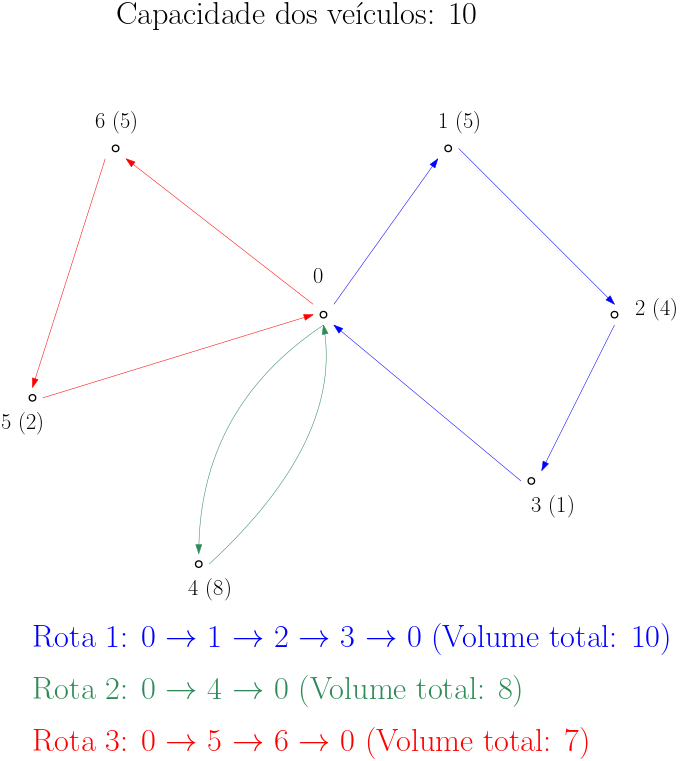


Você pode estar se perguntando: uma capacidade de 10 o quê? E o que é essa demanda? Em situações práticas, podemos usar volume, peso, dimensões (altura, largura e comprimento), ou até mesmo uma combinação entre estas medidas. Nestes casos, teríamos vários números para caracterizar cada entrega. Para simplificar, usamos um número só.

Neste caso, o problema é comumente encontrado na literatura como Problema de Roteamento de Veículos Capacitado, ou Capacitated Vehicle Routing Problem (CVRP). Por simplicidade, vamos continuar nos referindo a ele apenas por VRP.

## Resolvendo o VRP com o OR-Tools


Vamos resolver o mesmo problema de antes, mas agora incluindo demandas nos nós, como mostrado na imagem abaixo. Suponha que a capacidade de cada veículo seja igual a 10.



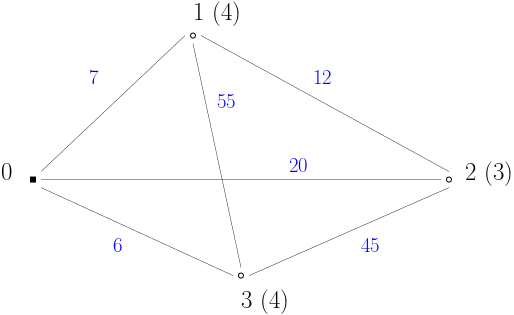

Como mencionado antes, o VRP é basicamente um mTSP com restrições, e no nosso caso, restrições de capacidade. Com isso, o procedimento para resolver este tipo de problema com o OR-Tools é essencialmente o mesmo, com a diferença de que incluímos um passo intermediário com a restrição de capacidade.

Vamos aos poucos como antes. Inicialmente, determinamos os dados do problema assumindo que temos 2 veículos disponíveis:

In [ ]:
import numpy as np
from ortools.constraint_solver import pywrapcp


# Matriz de distâncias (como antes)
distance_matrix = np.array([
    [0, 7, 20, 6],
    [7, 0, 12, 45],
    [20, 12, 0, 55],
    [6, 55, 45, 0],
])

# Demanda de cada nó (observe que o primeiro nó, de origem, possui demanda zero)
node_demands = [0, 4, 3, 4]
vehicle_capacity = 10

n = distance_matrix.shape[0]  # número de nós do problema
depot_node = 0  # número do nó que representa o ponto de origem
num_vehicles = 2
manager = pywrapcp.RoutingIndexManager(n, num_vehicles, depot_node)
routing = pywrapcp.RoutingModel(manager)

Todos os outros passos ocorrerão exatamente como antes. A diferença é que incluímos a restrição de capacidade da seguinte forma:

In [ ]:
def demand_callback(from_index):
    """Retorna a demanda de um nó"""
    from_node = manager.IndexToNode(from_index)
    return node_demands[from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    [vehicle_capacity] * num_vehicles,  # [10, 10]
    True,  # start cumul to zero
    'Capacity'
)

Parece uma forma complexa de adicionar esta restrição. O que acontece é que temos uma lista `node_demands` com as demandas de cada nó, mas como mencionado na aula anterior, o OR-Tools lida com índices internos diferentes. Assim, a função `demand_callback` basicamente serve para converter um índice interno em um nó e retornar o valor de sua demanda.

Além disso, o método `AddDimensionWithVehicleCapacity` adiciona esta restrição. Além da função que diz a demanda de cada nó, precisamos também de uma lista com as capacidades de cada veículo. Para isso, usamos a notação

```python
[vehicle_capacity] * num_vehicles
```

que cria uma lista repetindo o elemento `vehicle_capacity` um total de `num_vehicles` vezes. Por exemplo, se a capacidade é 10 e há 2 veículos, isto seria o mesmo de

```python
[10] * 2 = [10, 10]
```

Para o restante das variáveis, veja a [documentação](https://developers.google.com/optimization/routing/cvrp) se desejar mais detalhes.

No fim das contas, aqui está uma função que resolve o VRP. Ela possui a mesma estrutura do mTSP com a adição desta restrição de capacidade. Além disso, precisamos da demanda de cada nó e da capacidade dos veículos:

In [ ]:
from ortools.constraint_solver import pywrapcp


def solve_vrp_ortools(
    distance_matrix, node_demands, vehicle_capacity, num_vehicles=1
):
    n = distance_matrix.shape[0]  # número de nós do problema
    depot_node = 0  # número do nó que representa o ponto de origem
    manager = pywrapcp.RoutingIndexManager(n, num_vehicles, depot_node)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(i, j):
        # `i` e `j` são índices internos do OR-Tools. Precisamos primeiro
        # convertê-los em nós do nosso problema
        ni = manager.IndexToNode(i)
        nj = manager.IndexToNode(j)
        return distance_matrix[ni, nj]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Adiciona a restrição de capacidade
    def demand_callback(from_index):
        """Retorna a demanda de um nó"""
        from_node = manager.IndexToNode(from_index)
        return node_demands[from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback
    )
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        [vehicle_capacity] * num_vehicles,
        True,  # start cumul to zero
        'Capacity'
    )

    # Resolve o problema com métodos default
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    solution = routing.SolveWithParameters(search_parameters)

    # Constrói as rotas finais
    def create_vehicle_route(vehicle_index):
        route = []
        index = routing.Start(vehicle_index)
        node = manager.IndexToNode(index)
        route.append(node)

        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            node = manager.IndexToNode(index)
            route.append(node)
        return route

    routes = []
    for vehicle_index in range(num_vehicles):
        routes.append(create_vehicle_route(vehicle_index))

    return routes, solution.ObjectiveValue()

# Resolve o problema com nossa matriz usual
node_demands = [0, 4, 3, 4]
vehicle_capacity = 10
solve_vrp_ortools(distance_matrix, node_demands, vehicle_capacity, num_vehicles=2)

Observe como as rotas foram as mesmas no caso do mTSP. Experimente depois com outros números de veículos.

## Lidando com casos infactíveis

Há uma diferença muito importante entre os dois problemas. No mTSP, como não há restrições operacionais, sempre conseguimos rotas independente do número de caixeiros viajantes.

No VRP, se o número de veículos for muito pequeno, o problema pode não ter solução possível (o que chamamos de _infactível_). Por exemplo, se a capacidade dos veículos for reduzida para 5, com as demandas iguais a 4, 3 e 4, precisaríamos de ao menos 3 veículos para entregá-las. E até aí tudo bem:

In [ ]:
node_demands = [0, 4, 3, 4]
vehicle_capacity = 5
solve_vrp_ortools(distance_matrix, node_demands, vehicle_capacity, num_vehicles=3)

Contudo, se tentarmos resolver o problema com menos veículos, obtemos um erro:

In [ ]:
node_demands = [0, 4, 3, 4]
vehicle_capacity = 5
solve_vrp_ortools(distance_matrix, node_demands, vehicle_capacity, num_vehicles=2)

O erro ocorre porque a linha com o código que efetivamente resolve o problema,

```python
    solution = routing.SolveWithParameters(search_parameters)
```

retorna um elemento vazio `None`. Tente melhorar o código para retornar uma rota vazia em vez de falhar nestas situações (veja o Exercício 4).

# Resumo

Com esta aula, demos um novo passo em direção ao entendimento do problema descrito pelo LoggiBUD. Uma vez que a Loggi é uma empresa que lida com entregas, o Problema de Roteamento de Veículos é uma parte fundamental do nosso funcionamento.

Na aula seguinte, vamos começar a aplicar o conhecimento obtido até aqui em dados mais reais com o LoggiBUD.

# Exercícios

## Exercício 1


**Resolva o TSP a seguir para 1, 2, 3 e 4 caixeiros viajantes.**

Verifique a qualidade das soluções para cada caso.

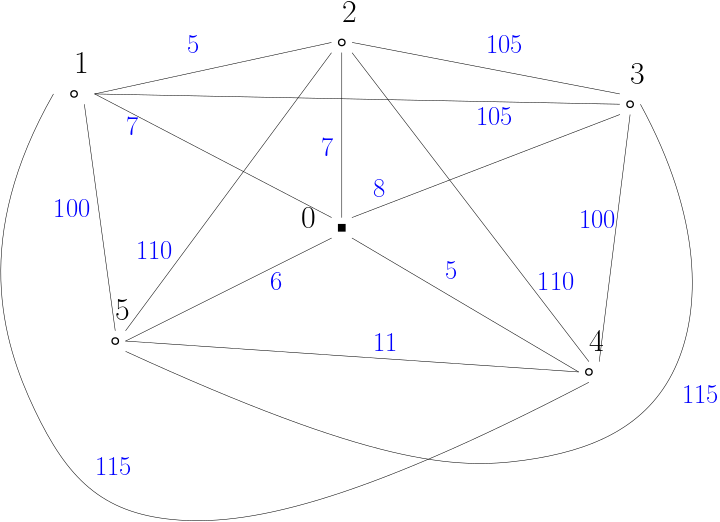

In [ ]:
# Programe aqui sua solução

## Exercício 2

**Em algumas situações existem vários caixeiros disponíveis, mas gostaríamos de saber qual o número que geraria o menor custo total. Escreva uma função para retornar, para uma dada matriz de distâncias, o número de caixeiros com melhores resultados.**

Dica 1: Usando a função desenvolvida nesta aula, comece com um caixeiro e aumente o número gradativamente até que não haja mais melhoria na distância total.

Dica 2: Teste seu programa tanto com o problema anterior quanto com uma matriz de números aleatórios de 0 a 199 com 100 nós.

In [ ]:
# Programe aqui sua solução

## Exercício 3

**Resolva o seguinte Problema de Roteamento de Veículos (VRP) para as seguintes capacidades de cada veículo:**

1. Capacidade: 7
2. Capacidade: 10
3. Capacidade: 20
4. Capacidade: 100

As demandas em cada nó são dadas entre parênteses.

Para cada caso, determine o número mínimo de veículos que retorna uma solução factível, e verifique a distância total em cada caso.

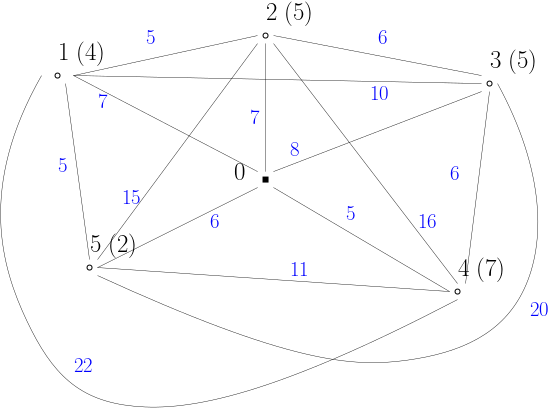


In [ ]:
# Programe aqui sua solução

## Exercício 4

**Aperfeiçoe nosso solver de VRPs.**

Nosso solver atual possui algumas falhas. Duas delas são:

- Se o problema não possuir solução, ele gera um erro em vez de tratá-lo de forma mais profissional como retornar uma rota vazia.
- Em vez de testar vários números de veículos até encontrar um que funciona (o que seria inviável em problemas grandes), podemos aproveitar do fato de que, se houver mais veículos que necessário, algumas rotas possuem apenas o nó 0 como origem e destino. Porém, não é interessante termos várias rotas inúteis quando apenas algumas efetivamente fazem entregas.

Neste exercício, melhore o nosso código resolvendo os problemas acima.

Dica 1: a variável `solution` tem o valor `None` caso não exista solução factível.

Dica 2: Ajuste o número de veículos para o máximo possível e remova ao final todas as rotas inúteis.

In [ ]:
# Programe aqui sua solução

## Exercício 5

**Desenvolva um avaliador de soluções de VRP**

Até o momento nós estamos confiando que o nosso solver retorna soluções factíveis, i.e., que respeitam as restrições do problema. Porém, e se houver um problema no código, ou trocarmos de solver, será que vale a pena confiar cegamente assim na sua solução?

Neste exercício você deve desenvolver uma função que verifica se a solução do problema está correta. Mais precisamente, ela deve avaliar:

1. Todos os nós estão contidos nas rotas?
2. A demanda total de cada rota não ultrapassa a capacidade dos veículos?

Sugestão: Crie uma função da seguinte forma

```python
is_feasible = evaluate_solution(routes, node_demands, vehicle_capacity)
```

que recebe as rotas retornadas pelo solver, as demandas de cada nó e a capacidade dos veículos e retorna um valor booleano com `True` se a solução for factível e `False` caso contrário.

Teste sua função com o código melhorado do exercício anterior para problemas com `n` = 10, 20, 50 e 100. Em cada caso, gere:

- a matriz de distâncias com números aleatórios de 1 a 100;
- as demandas com números aleatórios de 1 a 20, lembrando que a demanda do nó de origem deve sempre ser 0;
- e a capacidade do veículo igual a 40.

(Claro, experimente diversos outros valores depois se tiver interesse)

In [ ]:
# Programe aqui sua solução

## Exercício Suplementar

Assim como na aula anterior de TSP, estamos usando o solver do OR-Tools com parâmetros padrão. Experimente variar os algoritmos e resolva os exercícios anteriores com eles.

In [ ]:
# Programe aqui sua solução